# Balancing the Stroke Dataset with Undersampling

Finding how many people have a stroke and how many people do not.

In [3]:
import pandas as pd
df = pd.read_csv("data/dataset.csv")
print(df['stroke'].value_counts())

FileNotFoundError: [Errno 2] No such file or directory: 'data/dataset.csv'

Splitting them into stroke and non-stroke groups

In [31]:
stroke_cases = df[df['stroke'] == 1]
non_stroke_cases = df[df['stroke'] == 0]
print(len(stroke_cases), len(non_stroke_cases))

249 4861


Randomly Undersample Non-Stroke Cases, and Checking for Nulls

In [32]:
non_stroke_sample = non_stroke_cases.sample(n = len(stroke_cases), random_state=42)
df_balanced = pd.concat([stroke_cases,non_stroke_sample])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
print(df_balanced['stroke'].value_counts())
print("-------------------------------------\n")
print(df_balanced.isnull().sum())

stroke
0    249
1    249
Name: count, dtype: int64
-------------------------------------

id                    0
gender                0
age                   0
hypertension          0
heart_disease         0
ever_married          0
work_type             0
Residence_type        0
avg_glucose_level     0
bmi                  50
smoking_status        0
stroke                0
dtype: int64


# Data Cleaning and Preprocessing

Handling Missing Values (Null)

In [33]:
# Fill BMI missing values with the median
df_balanced['bmi'].fillna(df_balanced['bmi'].median(), inplace=True)
df_balanced.isnull().sum()

C:\Users\b00088656\AppData\Local\Temp\ipykernel_27704\2737377437.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_balanced['bmi'].fillna(df_balanced['bmi'].median(), inplace=True)


id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

One-Hot Encoding the Categorical Variables ---> gender, ever_married, work_type, Residence_type, smoking_status

In [34]:
df_balanced_encoded = pd.get_dummies(df_balanced, 
                                     columns=['gender', 'ever_married', 
                                              'work_type', 'Residence_type', 
                                              'smoking_status'], 
                                     drop_first=True)

Seperate Our Features from Our Targets

In [35]:
X = df_balanced_encoded.drop('stroke', axis = 1)        ##Axis = 1 --> Drop column not row
y = df_balanced_encoded['stroke']

Scaling Features

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Splitting Training Data and Testing Data (80-20)

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Data Modeling

### Model #1 --> Logistic Model (Our Baseline)

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression Results
Accuracy: 0.71
[[35 15]
 [14 36]]
              precision    recall  f1-score   support

           0       0.71      0.70      0.71        50
           1       0.71      0.72      0.71        50

    accuracy                           0.71       100
   macro avg       0.71      0.71      0.71       100
weighted avg       0.71      0.71      0.71       100



### Random Forest Model (Improved Model)

In [39]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Results
Accuracy: 0.73
[[36 14]
 [13 37]]
              precision    recall  f1-score   support

           0       0.73      0.72      0.73        50
           1       0.73      0.74      0.73        50

    accuracy                           0.73       100
   macro avg       0.73      0.73      0.73       100
weighted avg       0.73      0.73      0.73       100



Feature Importance with Random Forest (Which Features are the Most Important?)

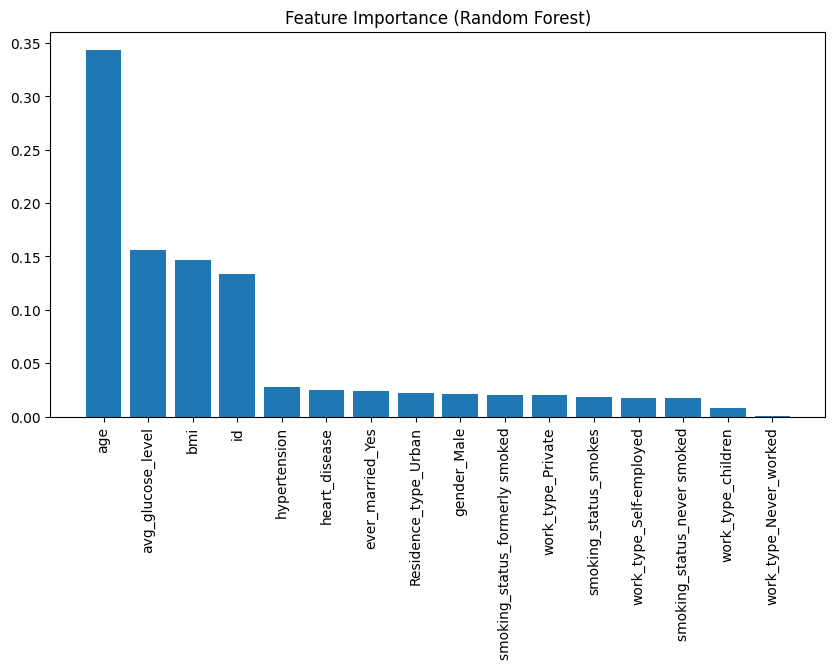

In [40]:
import matplotlib.pyplot as plt
import numpy as np
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns
plt.figure(figsize=(10,5))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.title("Feature Importance (Random Forest)")
plt.show()

### Saving Predictions for Power BI Analysis

In [41]:
# Save results
df_results = pd.DataFrame(X_test, columns=X.columns)
df_results['Actual'] = y_test.values
df_results['Predicted'] = y_pred_rf
df_results.to_csv("stroke_predictions.csv", index=False)